Adam as intended, Lambda:  0.001  Epochs:  50  delta  0.3


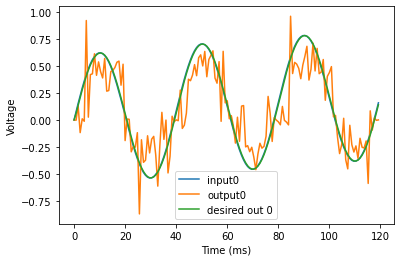

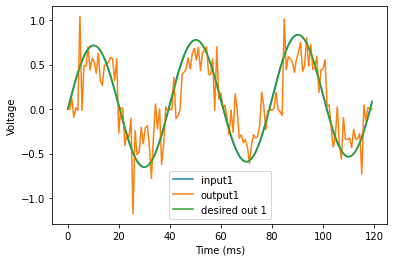

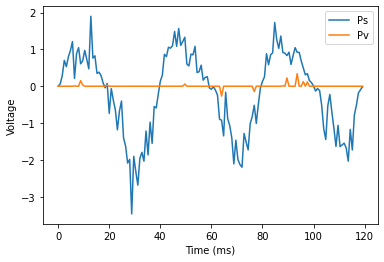

UO


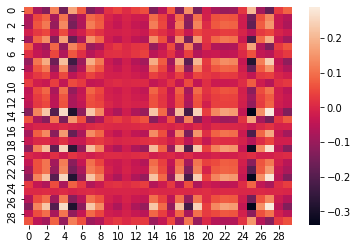

Wf


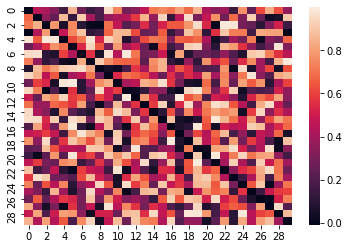

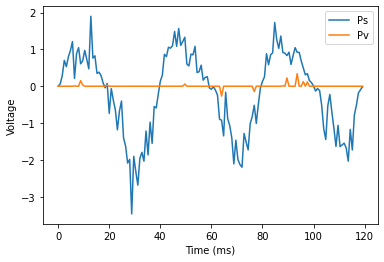

Comparing output with desired output: 

Standard deviation of abs(o-od):  0.13040042


Accuracy:  0.72  with tolerance:  0.25
*Note that this is not the most suitable method of accuracy measurement
Adam as intended, Lambda:  0.001  Epochs:  50  delta  0.5


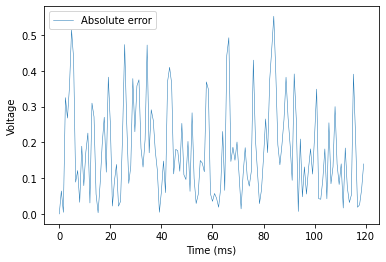

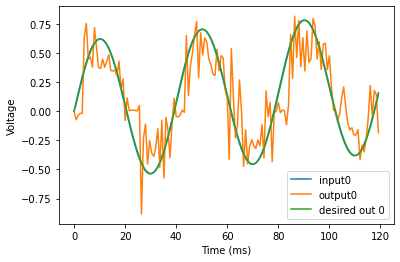

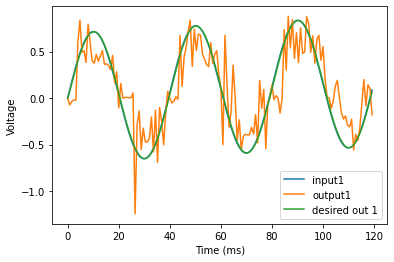

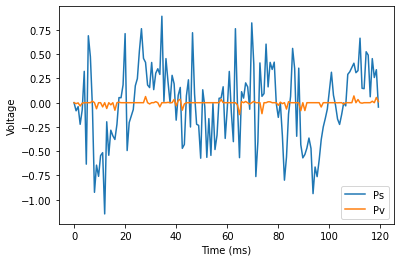

UO


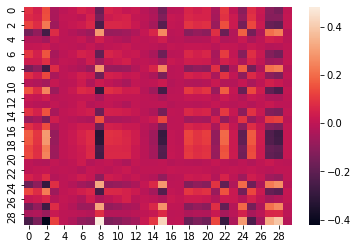

Wf


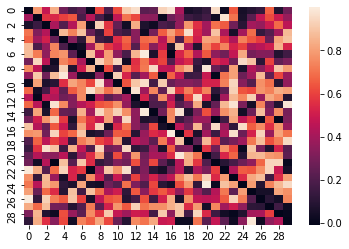

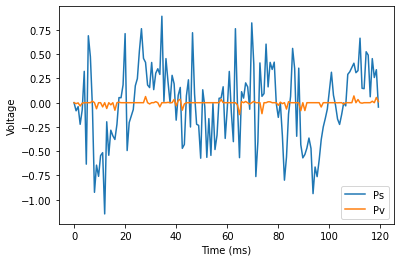

Comparing output with desired output: 

Standard deviation of abs(o-od):  0.12774983


Accuracy:  0.7466666666666667  with tolerance:  0.25
*Note that this is not the most suitable method of accuracy measurement
Adam as intended, Lambda:  0.001  Epochs:  50  delta  0.8


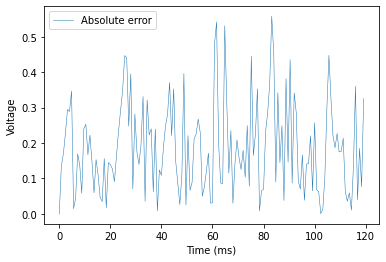

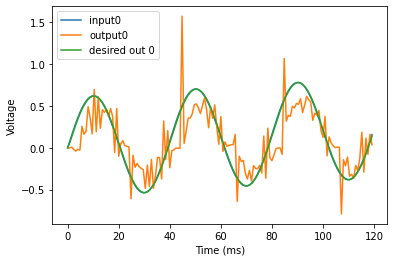

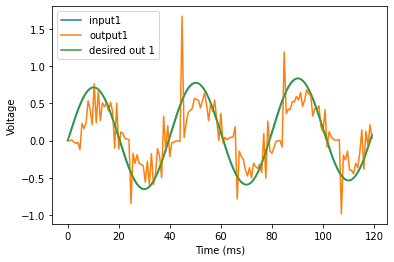

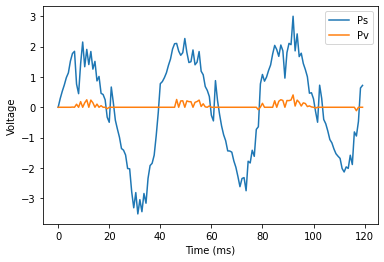

UO


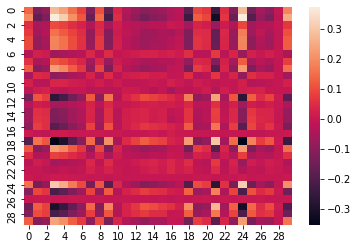

Wf


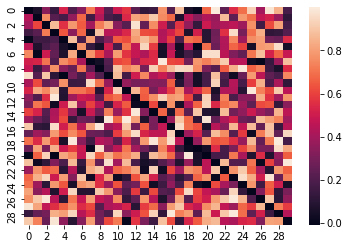

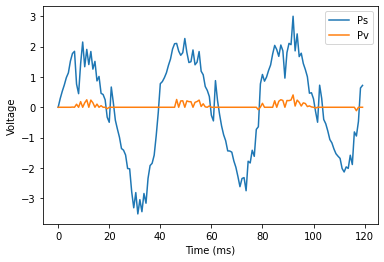

Comparing output with desired output: 

Standard deviation of abs(o-od):  0.14375016


Accuracy:  0.62  with tolerance:  0.25
*Note that this is not the most suitable method of accuracy measurement


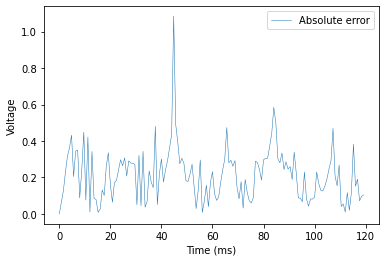

In [2]:
import math
import numpy as np
from matplotlib.pyplot import *
import seaborn as sns

A = 1 #amplitude
f1 = 1/40. 
f2 = 1/1200.
deltat = 0.8
total_time = int(120 / deltat) #120ms
mini_batch_samples = 15

#Threshold voltages for input and output neurons
vthr=1
vthr_neg= -vthr
dlta=[0.3, .5,.8]
v_reset = 0


#Time constants for fast and regular synapses
s_tau=10 #10ms
sf_tau=1 #1ms

#function to add label to graph
def addLabel():
    xlabel('Time (ms)')
    ylabel('Voltage')
    legend()

#Other parameters
#lmbda=0.0001
lmbda = 0.1

epochs = [50]
lmba=[0.001]
learning_rate = 0.01
 # learning rate for O variable
LR2 = 0.04

N = 30 #number of neurons
num_inputs = 2
num_outputs = 2
batch_num = 1
mini_batch_n = 1
Nparams= N*N + N*num_inputs + N*num_outputs + N


for delta in dlta:
  for max_epochs in epochs:
    for lmbda in lmba:
      print('Adam as intended, Lambda: ', lmbda, " Epochs: ", max_epochs,' delta ', delta)


      I = np.zeros((num_inputs),np.float32)
      I0 = np.zeros((N),np.float32) #tonic current
      Wo = 1.
      W = Wo*np.random.random((N,N)).astype(np.float32) 
      Uo = 2.
      U = Uo*np.random.random((N,num_inputs)).astype(np.float32) - (Uo/2)
      v = np.zeros((N),np.float32)
      g = np.zeros((N, total_time),np.float32)
      s = np.zeros((N,total_time),np.float32)


      pv = np.zeros((N,total_time),np.float32) 
      ps = np.zeros((N,total_time),np.float32)
      psdot = np.zeros((N,total_time),np.float32)


      Oo = 0.1
      O = Oo * np.random.random((num_outputs,N)).astype(np.float32) - 0.05
      o = np.zeros((num_inputs,total_time),np.float32)
      od = np.zeros((num_inputs,total_time),np.float32)
      inputs = np.zeros((num_inputs,total_time),np.float32)

      dl_s = np.zeros((N),np.float32)

      dW = np.zeros((N,N),np.float32)
      dO = np.zeros((num_inputs,N),np.float32) 
      dU = np.zeros((N,num_inputs), np.float32)

      plotTime = []
      plotTime.append(time)

      current = np.zeros((N,total_time),np.float32)

      Ohalf = O
      Wf = np.zeros((N,total_time),np.float32)
      UO = np.zeros((N,N),np.float32)
      V = np.zeros((N,total_time),np.float32)

      p0 = -1

      convergeW = False

      wTime = np.zeros((max_epochs),np.float32)
      uTime = np.zeros((max_epochs),np.float32)
      oTime = np.zeros((max_epochs),np.float32)
      iTime = np.zeros((max_epochs),np.float32)


        # 
      for it in range(max_epochs):
        plotTime = []; time = 0; plotTime.append(time)
        mini_batch_n = 1

    ## FORWARD FEED    
        for i in range(1,total_time):
            #print("Epoch: ", it, "feedforward: " , i)
            time=time+deltat
            plotTime.append(time)
            
            s1 = 0.6*np.sin(2 * math.pi * f1 * time)
            s2 = 0.4*np.sin(2 * math.pi * f2 * time)
            s3 = 0.7*np.sin(2 * math.pi * f1 * time)
            s4 = 0.3*np.sin(2 * math.pi * f2 * time)
            inputs[:,i] = [A*(s1+s2), A*(s3+s4)]
            
            np.fill_diagonal(W, 0)
        # fully connected network structure
            
            I = np.matmul(W,s[:,i]) + A*np.matmul(U,inputs[:,i]) +  I0
            current[:,i] =I[:]      
            
            v = v + (deltat*I)
            
            # gating and threshold
            g[:,i] = np.where(np.logical_or(np.logical_and(v > (vthr - delta),(v <= vthr)), np.logical_and(v >= (-vthr),(v < -vthr + delta))),1./delta,0.) 
            v[v>=vthr] = v_reset
            
            s[:,i] = s[:,i] + deltat*(-s[:,i] + g[:,i]*I)/s_tau
            
            o[:,i] = np.matmul(O,s[:,i])
            #o[:,i] = np.einsum('jk,k->',O, s[:,i])
            #od[:,i] = (-od[:,i-1] + (inputs[:,i]))/sf_tau
            od[:,i] = od[:,i-1]+ deltat * (-od[:,i-1] + inputs[:,i])/sf_tau
            V[:,i] = v
            
            
    ## BACKWARD IN TIME -- PMP            
            if (i == mini_batch_n * mini_batch_samples) or (i == total_time - 1):
            
                for j in range(i, (mini_batch_n - 1)*mini_batch_samples, -1):
                    
                    #print("Epoch: ", it, "batch: ", mini_batch_n, "batch backprop: " , j)
                    dl_s= np.matmul(O.T,(o[:,j]-od[:,j]))  +  lmbda*s[:,j]
                                
                    psdot[:,j-1] = (ps[:,j] + dl_s  -  np.matmul(W.T, pv[:,j]))/s_tau
                    pvdot =  -pv[:,j] + g[:,j]*psdot[:,j-1]
                    
                    ps[:,j] = ps[:,j] + deltat * psdot[:,j-1]
                    pv[:,j] = pv[:,j] + deltat * pvdot 
                    
                mini_batch_n += 1 

              
            
            #update after going through all the batches
            if i == total_time - 1:
                  
                
                # weight update should be done after entire epoch (after batch)
                #dW = np.multiply(pv,s)/s_tau
                dW = (np.einsum('ik,jk->ij', pv, s) / s_tau)  # .reshape(N,N)
                W = W + learning_rate*dW 
                
                #dO = p0*np.matmul((o - od),s.T)/s_tau
                dO = p0* np.einsum('ik,jk->ij', (o-od), s)/ s_tau # reshape(num_input, N)
                O = O + LR2*dO
        
                #dU = np.matmul(pv, inputs.T) / s_tau
                dU = (np.einsum('ik,jk->ij', pv, inputs) / s_tau)  # .reshape(N, num_input)
                U = U + learning_rate*dU
              
                dI0 = (np.einsum('jk->j', pv) / s_tau)  # .reshape(N,1)
                I0  = I0 + learning_rate*dI0
                
                if(it == max_epochs/2):
                    Ohalf = O
          
        if it == max_epochs-1:
          
            figure(1)
            plot(plotTime, inputs[0,:], label = 'input0')
            plot(plotTime,o[0,:], label='output0')
            plot(plotTime,od[0,:], label='desired out 0')
            addLabel()
            show()
            
            figure(2)
            plot(plotTime, inputs[1,:], label = 'input1')
            plot(plotTime,o[1,:], label='output1')
            plot(plotTime,od[1,:], label='desired out 1')
            addLabel()
            show()
            
            figure(3)
            plot(plotTime,ps[1,:], label='Ps')
            plot(plotTime,pv[1,:],label='Pv')
            addLabel()
            show()
        
            
            UO = np.negative(np.matmul(U,O))
    #        plot heatmap
            print("UO")
            figure(4)
            m1 = sns.heatmap(UO)
            show()
            
            print("Wf")
            figure(5)
            m3 = sns.heatmap(W)    
            show()

            figure(6)
            plot(plotTime,ps[1,:], label='Ps')
            plot(plotTime,pv[1,:],label='Pv')
            addLabel()
            show()

            print("Comparing output with desired output: \n")
            tolerance = 0.25
            std0 = np.std(np.abs(o[0,:]-od[0,:]))
            print("Standard deviation of abs(o-od): ", std0)
            print("\n")
            #Compute error rate
            accuracy = (np.abs(o[0,:] - od[0,:]) < tolerance ).mean()
            print("Accuracy: ", accuracy , " with tolerance: ", tolerance)
            print("*Note that this is not the most suitable method of accuracy measurement")
            diff = od[0,:]-o[0,:]
            abs_err = np.abs(diff)
            realy = od[0,:]
            figure(3)
            plot(plotTime, abs_err, lw=.5, label='Absolute error')
            addLabel()